<a href="https://colab.research.google.com/github/venkataramanik/Supplychain/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🏭 GRU-Based Demand Forecasting – Use Case

### 🔍 Why GRU?
Gated Recurrent Units (GRU) are a type of Recurrent Neural Network (RNN) designed to capture patterns in sequential data — like weekly or daily demand. They are lighter and faster than LSTM but still handle long-term dependencies well.

---

### 🚛 Supply Chain Use Cases

#### 📦 Retail & Inventory
- Forecast SKU-level demand at weekly or daily frequency
- Helps avoid stockouts or overstock situations
- Especially useful for **new or volatile product categories**

#### 🧯 Spare Parts & MRO
- Predict irregular but critical spare part demand
- Reduces working capital while ensuring availability

#### 🛒 E-Commerce Fulfillment
- Models order surge patterns around holidays/promotions
- Supports automated replenishment decisions

#### 🚚 Last-Mile Delivery Logistics
- GRU can predict **package volume trends** by zip code or route
- Optimizes driver scheduling and warehouse staffing

---

### 📈 What This Project Shows
- How GRU can model non-linear, seasonal demand
- How to scale and prepare time series data
- Forecasting performance via **MAPE** evaluation


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


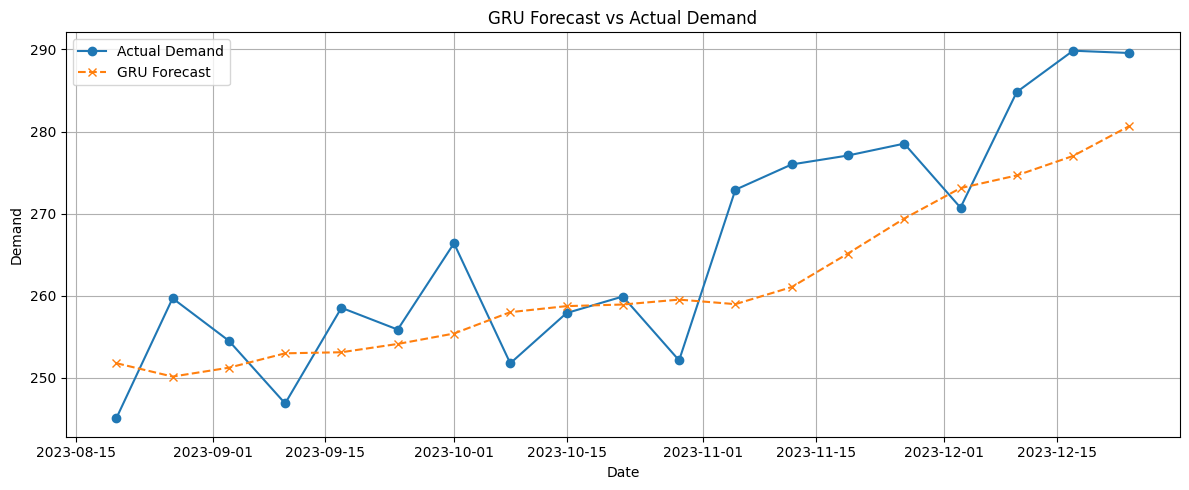

MAPE: 2.80%


In [1]:
# 📦 Install dependencies
!pip install -q tensorflow scikit-learn

# 📚 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# 🧪 Simulate Weekly Demand Data (e.g., Retail SKU)
np.random.seed(42)
weeks = pd.date_range(start='2022-01-01', periods=104, freq='W')
trend = np.linspace(100, 300, 104)
seasonality = 20 * np.sin(np.arange(104) * (2 * np.pi / 52))
noise = np.random.normal(0, 10, 104)
demand = trend + seasonality + noise

df = pd.DataFrame({
    'Date': weeks,
    'Demand': demand
})

# 📉 Normalize demand
scaler = MinMaxScaler()
df['Scaled_Demand'] = scaler.fit_transform(df[['Demand']])

# 🔁 Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(df['Scaled_Demand'].values, window_size)

# 🧪 Train/Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1], 1))

# 🧠 Build GRU model
model = Sequential()
model.add(GRU(50, activation='tanh', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 🚀 Train
model.fit(X_train, y_train, epochs=50, verbose=0)

# 🔮 Predict
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 📊 Plot actual vs. forecast
plt.figure(figsize=(12, 5))
plt.plot(df['Date'][-len(y_test):], y_test_rescaled, label='Actual Demand', marker='o')
plt.plot(df['Date'][-len(y_test):], y_pred_rescaled, label='GRU Forecast', linestyle='--', marker='x')
plt.title('GRU Forecast vs Actual Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 MAPE Score
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f"MAPE: {mape*100:.2f}%")
